In [1]:
import sys
sys.path.append('..')
from myfunctions_dataloader import mydataloader_cv

In [2]:
import os
import pickle
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sb
from hmmlearn import hmm
from sklearn.metrics import confusion_matrix as cm
from scipy import signal
from scipy.fftpack import fft, fftshift

from myfunctions_HMMEOG import *

In [105]:
# load the data (already preprocessed)
path = 'C:/Users/Javi/Documents/GitHub/TFM/example_processed_data_v5'
d = mydataloader_cv()
d.load_data(path,5, 20)

 
There are less files than the provided maximum
shhs1-200001 loaded!
shhs1-200002 loaded!
shhs1-200003 loaded!
shhs1-200004 loaded!
shhs1-200005 loaded!
shhs1-200006 loaded!
shhs1-200007 loaded!
shhs1-200008 loaded!
shhs1-200009 loaded!
shhs1-200010 loaded!
shhs1-200011 loaded!
shhs1-200012 loaded!
shhs1-200013 loaded!
shhs1-200014 loaded!
shhs1-200015 loaded!
shhs1-200016 loaded!
shhs1-200017 loaded!
shhs1-200018 loaded!
shhs1-200019 loaded!
shhs1-200020 loaded!
Validation subjects in fold 0 [ 0  1 15 17]
Validation subjects in fold 1 [ 3  5  8 11]
Validation subjects in fold 2 [ 2 13 16 18]
Validation subjects in fold 3 [ 4  9 12 19]
Validation subjects in fold 4 [ 6  7 10 14]


In [11]:
labels = ['Wake','N1','N2','N','REM']
clusters = [[0], [1], [2], [3], [4]]
Fs = 50
pEOG = np.concatenate([d.pEOG[i] for i in range(20)], axis=0)
hyp  = np.concatenate([d.hypnogram[i] for i in range(20)], axis=0)
 
H = hypnogram_vec2mat(hyp, clusters)
fullEOG, fullH = flatten_data(pEOG,H)
# spectrogram, spectH = myspectrogram(fullEOG[:,0], 30*Fs, int(0.5*Fs), fullH)
from scipy import signal
spect = np.array([[signal.spectrogram(pEOG[i, 0, :], fs=Fs, nperseg=30*Fs,# noverlap=int(Fs/2),
                                      scaling='spectrum')[2]]
                  for i in range(len(pEOG))])

In [12]:
specgram = spect.squeeze()

In [13]:
thresh = 5
specgram /= specgram.max()  # volume normalize to max 1
specgram = np.log10(specgram)  # take log
specgram[specgram < -thresh] = -thresh  # set anything less than the threshold as the threshold

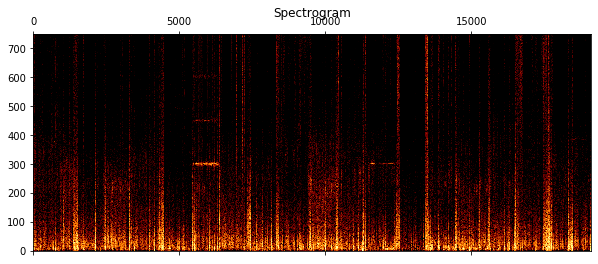

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
cax = ax.matshow(
    np.transpose(specgram),
    interpolation="nearest",
    aspect="auto",
    cmap=plt.cm.afmhot,
    origin="lower")
plt.title("Spectrogram")
plt.xlim(0, len(specgram))
plt.show()

In [15]:
def average_spectrogram_by_regions(spectrogram, freq_limits):
    L = spectrogram.shape[1]
    n = spectrogram.shape[0]
    bin_limits = []
    for i in range(len(freq_limits)):
        bin_limits.append(int(freq_limits[i]*L/25)) # max freq is 25 Hz
        
    new_spect = np.zeros((n,len(bin_limits)-1))
    for i in range(n):
        for j in range(len(bin_limits)-1):
            new_spect[i,j] = np.mean(spectrogram[i,bin_limits[j]:bin_limits[j+1]])
    return new_spect

In [16]:
freq_bands = [0,0.5,1,2,3,4,6,8,12,16,20,25]
specgram_bands = average_spectrogram_by_regions(specgram, freq_bands)

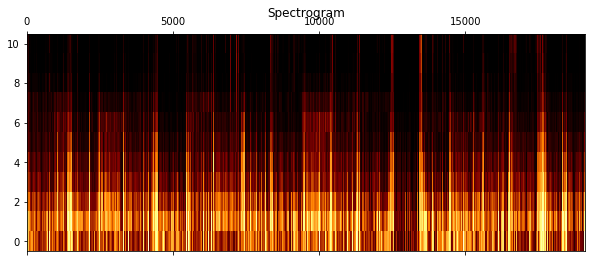

In [17]:
# after mean by bands
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
cax = ax.matshow(
    np.transpose(specgram_bands),
    interpolation="nearest",
    aspect="auto",
    cmap=plt.cm.afmhot,
    origin="lower")
plt.title("Spectrogram")
plt.xlim(0, len(specgram_bands))
plt.show()
# I would need to include proper y axis (in freq) and move x labels below
# also use x and y label
# also proper Y axis (proper scale, it is not linear now)

In [18]:
specgram_bands.shape

(19093, 11)

In [19]:
N = 4
modelk = hmm.GaussianHMM(n_components=N, covariance_type="diag",n_iter=1000)
modelk.fit(specgram_bands)
assert modelk.monitor_.converged, "HMM model did not converge"
# make a prediction of states over the data
states_predict = modelk.predict(specgram_bands)
Z = modelk.predict_proba(specgram_bands)

# Figures

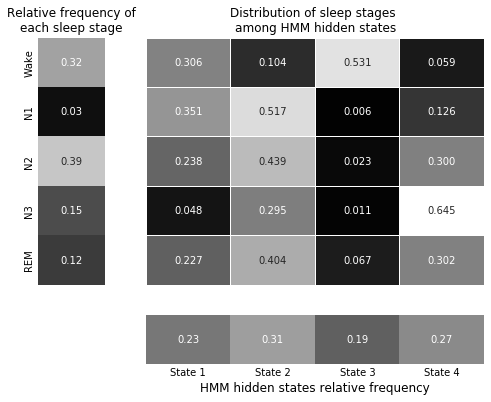

In [67]:
corr_matrix = obtain_correlation_matrix(H,Z,makeplots =True,hypnogram_labels=labels,mode='nonorm')

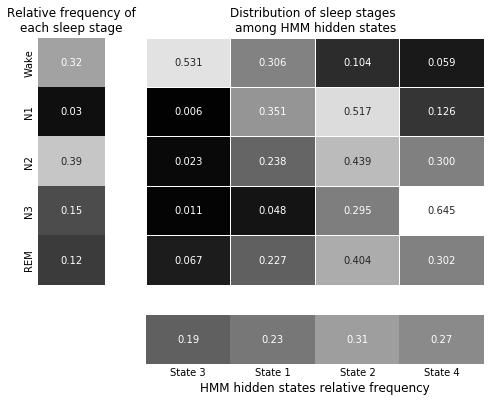

In [68]:
state_order = [2,0,1,3]
new_corr = rearrange_states(corr_matrix, state_order)
plotCM(new_corr, states=state_order)

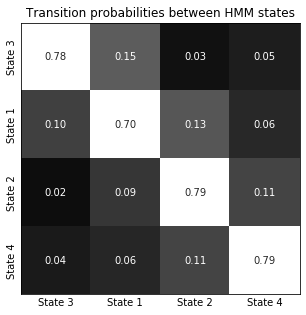

In [50]:
new_transmat = rearrange_transmat(modelk.transmat_, state_order, makeplots=True)